# Perform full registration (rigid and chunked)

In [33]:
import sys
sys.path.insert(0, '..')
import pwreg
import torch
import torch.nn.functional as F
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

In [2]:
# Load dataset and downsample
X = pwreg.Dataset('../data/nissl_2.nii.gz', '../data/tau_2.nii.gz', '../data/nissl_chunk_mask_2.nii.gz', torch.float)
I_fix, I_mov, I_fmsk = X.I_fix.downsample(1/8.), X.I_mov.downsample(1/8.), X.M_fix.downsample(1/8.)

In [3]:
# Solve the registration problem with a single block mask
I_nomask = pwreg.Image2D(torch.sum(I_fmsk.T, axis=0, keepdim=True), I_fmsk.ras)
R_nomask = pwreg.RigidProblem(I_fix, I_mov, I_nomask)

theta, dx, dy = pwreg.RigidProblemOptimizer.make_init_param(1, 0.2, -0.1, 0.2)
Q_init = R_nomask.apply_tform_to_moving(R_nomask.compute_tform(theta, dx, dy))

RO_nomask = pwreg.RigidProblemOptimizer(R_nomask, 0.0)
hist, ncc_val, ovl_val = RO_nomask.optimize(theta, dx, dy, 100)
Q_opt = R_nomask.apply_tform_to_moving(R_nomask.compute_tform(theta, dx, dy))

Iter 000 NCC:   0.6080, OVL:  -0.0168, OBJ:   0.3920, 
Iter 001 NCC:   0.6745, OVL:  -0.0172, OBJ:   0.3255, 
Iter 002 NCC:   0.7242, OVL:  -0.0173, OBJ:   0.2758, 
Iter 003 NCC:   0.7342, OVL:  -0.0173, OBJ:   0.2658, 
Iter 004 NCC:   0.7349, OVL:  -0.0173, OBJ:   0.2651, 
Iter 005 NCC:   0.7362, OVL:  -0.0173, OBJ:   0.2638, 
Iter 006 NCC:   0.7370, OVL:  -0.0174, OBJ:   0.2630, 
Iter 007 NCC:   0.7370, OVL:  -0.0174, OBJ:   0.2630, 
Iter 008 NCC:   0.7371, OVL:  -0.0174, OBJ:   0.2629, 
Iter 009 NCC:   0.7374, OVL:  -0.0175, OBJ:   0.2626, 
Iter 010 NCC:   0.7374, OVL:  -0.0175, OBJ:   0.2626, 
Iter 011 NCC:   0.7391, OVL:  -0.0175, OBJ:   0.2609, 
Iter 012 NCC:   0.7393, OVL:  -0.0174, OBJ:   0.2607, 
Iter 013 NCC:   0.7502, OVL:  -0.0177, OBJ:   0.2498, 
Iter 014 NCC:   0.7635, OVL:  -0.0172, OBJ:   0.2365, 
Iter 015 NCC:   0.7646, OVL:  -0.0172, OBJ:   0.2354, 
Iter 016 NCC:   0.7653, OVL:  -0.0169, OBJ:   0.2347, 
Iter 017 NCC:   0.7662, OVL:  -0.0170, OBJ:   0.2338, 
Iter 018 N

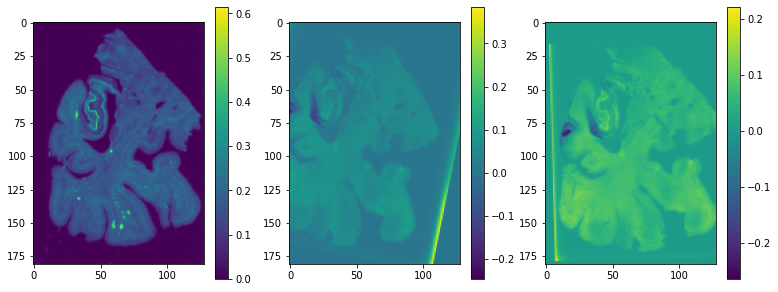

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 5), ncols=3);
fig.colorbar(ax1.imshow(R_nomask.I_fix.T.squeeze()), ax=ax1);
fig.colorbar(ax2.imshow(Q_init[0,0,:,:].detach()), ax=ax2);
fig.colorbar(ax3.imshow(Q_opt[0,0,:,:].detach()), ax=ax3);

In [26]:
# Solve the registration problem with piecewise mask
R_chunk = pwreg.RigidProblem(I_fix, I_mov, I_fmsk)

theta2, dx2, dy2 = pwreg.RigidProblemOptimizer.make_init_param(8, theta.item(), dx.item(), dy.item())
Q_init = R_chunk.apply_tform_to_moving(R_chunk.compute_tform(theta2, dx2, dy2))

RO_chunk = pwreg.RigidProblemOptimizer(R_chunk, 1.0)
hist, ncc_val, ovl_val = RO_chunk.optimize(theta2, dx2, dy2, 100)
Q_opt = R_chunk.apply_tform_to_moving(R_chunk.compute_tform(theta2, dx2, dy2))
M_inv = R_chunk.ovl.overlap_image(torch.inverse(R_chunk.compute_tform(theta2, dx2, dy2)))

Iter 000 NCC:   0.7981, OVL:  -0.0170, OBJ:   1.5981, 
Iter 001 NCC:   0.8011, OVL:  -0.0102, OBJ:   1.5808, 
Iter 002 NCC:   0.8064, OVL:  -0.0116, OBJ:   1.5373, 
Iter 003 NCC:   0.8072, OVL:  -0.0054, OBJ:   1.5370, 
Iter 004 NCC:   0.8101, OVL:  -0.0081, OBJ:   1.5107, 
Iter 005 NCC:   0.8119, OVL:  -0.0043, OBJ:   1.5005, 
Iter 006 NCC:   0.8136, OVL:  -0.0014, OBJ:   1.4895, 
Iter 007 NCC:   0.8135, OVL:  -0.0040, OBJ:   1.4883, 
Iter 008 NCC:   0.8137, OVL:  -0.0040, OBJ:   1.4866, 
Iter 009 NCC:   0.8141, OVL:  -0.0032, OBJ:   1.4841, 
Iter 010 NCC:   0.8141, OVL:  -0.0030, OBJ:   1.4839, 
Iter 011 NCC:   0.8143, OVL:  -0.0030, OBJ:   1.4828, 
Iter 012 NCC:   0.8144, OVL:  -0.0024, OBJ:   1.4826, 
Iter 013 NCC:   0.8144, OVL:  -0.0025, OBJ:   1.4825, 
Iter 014 NCC:   0.8144, OVL:  -0.0023, OBJ:   1.4824, 
Iter 015 NCC:   0.8145, OVL:  -0.0016, OBJ:   1.4822, 
Iter 016 NCC:   0.8144, OVL:  -0.0031, OBJ:   1.4817, 
Iter 017 NCC:   0.8146, OVL:  -0.0024, OBJ:   1.4808, 
Iter 018 N

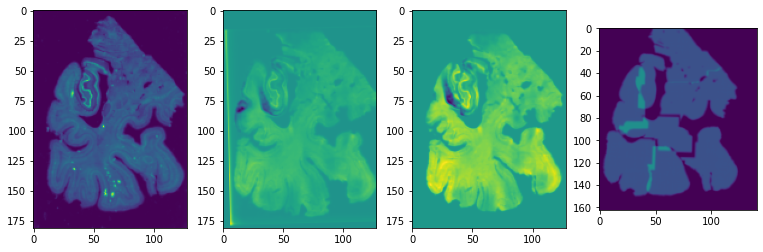

In [27]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(13, 4), ncols=4);
ax1.imshow(R_chunk.I_fix.T.squeeze(), aspect='equal')
ax2.imshow(Q_opt[4,0,:,:].detach(), aspect='equal')
ax3.imshow(torch.sum(Q_opt * R_chunk.M_fix.T, axis=0).squeeze().detach(), aspect='equal')
ax4.imshow(torch.sum(M_inv, axis=0).squeeze().detach(), vmin=0, vmax=4, aspect='equal')

In [30]:
kernel = pwreg.Image2D.gaussian_fft_kernel(R_chunk.I_fix.T, 3.0)
Msm = pwreg.Image2D.pytorch_gaussian_lpf(R_chunk.M_fix.T, 3.0, kernel)

In [52]:
A=R_chunk.compute_tform(theta2, dx2, dy2)
phi = torch.permute(
      F.affine_grid(A[:, 0:2, :], R_chunk.M_fix.T.shape, align_corners=False) -
      F.affine_grid(A[:, 0:2, :] * 0., R_chunk.M_fix.T.shape, align_corners=False), (0,3,1,2))
phi_sm = pwreg.Image2D.pytorch_gaussian_lpf(phi * R_chunk.M_fix.T, 3.0, kernel)

In [62]:
phi_test = torch.mean(phi_sm, axis=0) / (0.000001 + torch.mean(Msm, axis=0))

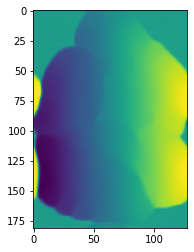

In [74]:
plt.imshow(phi_test[1,:,:].detach())

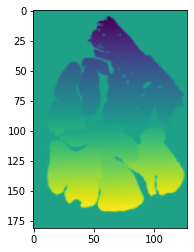

In [73]:
plt.imshow(torch.sum(phi * R_chunk.M_fix.T, axis=0)[1,:,:].detach())

In [66]:
Q_test = F.grid_sample(R_chunk.I_mov.T, phi_test.permute(1,2,0).unsqueeze(0), align_corners=False)

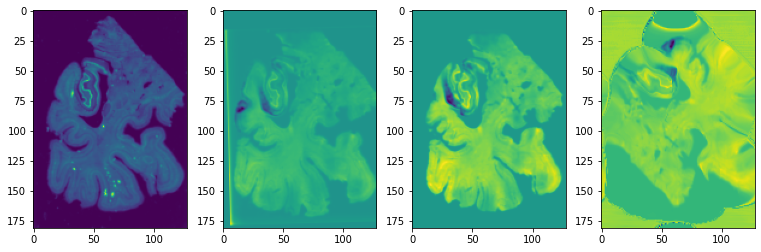

In [68]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(13, 4), ncols=4);
ax1.imshow(R_chunk.I_fix.T.squeeze(), aspect='equal')
ax2.imshow(Q_opt[4,0,:,:].detach(), aspect='equal')
ax3.imshow(torch.sum(Q_opt * R_chunk.M_fix.T, axis=0).squeeze().detach(), aspect='equal')
ax4.imshow(Q_test.squeeze().detach(), aspect='equal')

In [69]:
phi_test.permute(1,2,0).unsqueeze(0).shape

torch.Size([1, 181, 128, 2])